In [19]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from plotly.subplots import make_subplots
from pymatgen.phonon.plotter import PhononBSPlotter
import plotly.graph_objects as go
from mp_api.client import MPRester
import math

## Récupération de la densité d'états de phonons de ZrFeTe 

In [11]:
def get_plot_dos(dos, plot_range = [None,None]):
    fig = go.Figure()
    if not "phonon" in str(type(dos)):
        xvals = dos.energies - dos.efermi
        xaxis_title = "E - E<sub>f</sub> (eV)"
        yvals = list(dos.densities.values())[0]
    else:
        xvals = dos.frequencies
        xaxis_title = "Frequencies (THz)"
        yvals = dos.densities

    scatter = go.Scatter(x=xvals, y=yvals, mode="lines")
    fig.add_trace(scatter)
    
    if plot_range == [None, None]:
        xaxis_range = [np.min(xvals)-0.02*abs(np.min(xvals)), np.max(xvals)+0.02*abs(np.max(xvals))]
        yaxis_range = [0, 1.02*np.max(yvals)]
    elif plot_range[0] == None:
        xaxis_range = [np.min(xvals)-0.02*abs(np.min(xvals)), plot_range[1]]
        i1 = np.argmin(abs(xvals-plot_range[1]))
        yaxis_range = [0, 1.02*np.max(yvals[:i1])]
    elif plot_range[1] == None:
        xaxis_range = [plot_range[0], np.max(xvals)+0.02*abs(np.max(xvals))]
        i0 = np.argmin(abs(xvals-plot_range[0]))
        yaxis_range = [0, 1.02*np.max(yvals[i0:])]
    else: 
        xaxis_range = [plot_range[0], plot_range[1]]
        i0 = np.argmin(abs(xvals-plot_range[0]))
        i1 = np.argmin(abs(xvals-plot_range[1]))
        yaxis_range = [0, 1.02*np.max(yvals[i0:i1])]
    
    fig.update_layout(
        xaxis =  {'mirror': True, 'showgrid': False, 'ticks': 'inside', 'ticklen':10},
        yaxis =  {'mirror': True, 'showgrid': False, 'ticks': 'inside', 'ticklen':10},
        xaxis_range = xaxis_range,
        yaxis_range = yaxis_range,
        xaxis_title = xaxis_title,
        yaxis_title = "DOS",
    )
    return fig

In [12]:
mp_key = "8ChDIqwByRyXhuV8q0dfcUVnIxLTB4o7"
mp_id = "mp-961649"

In [13]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
figure = get_plot_dos(ph_dos)
figure.show()

In [15]:
cv_test = ph_dos.cv(15)
print(cv_test)

0.3848303068808072


In [16]:
kb = 1.38064852e-23 #constante de boltzmann
h = 6.62607015e-34
T= np.arange(0.001,1000,5) #temperature
R = 8.314 
nat = len(prim_struc) #nombre d'atomes 
freq = ph_dos.frequencies
densities = ph_dos.densities
cv_list = []
for temp in T:
    cv_list.append(ph_dos.cv(temp))
cv_list = np.array(cv_list) / (3 * nat * R)

### Graphe de la courbe basée sur les données de DOS

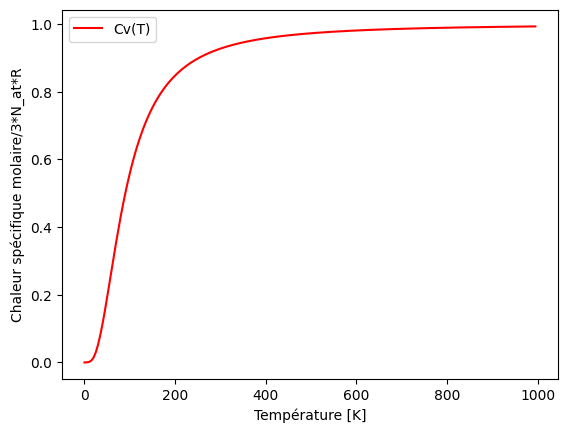

In [17]:
plt.plot(T, cv_list, color="red", label="Cv(T)")
plt.xlabel("Température [K]")
plt.ylabel("Chaleur spécifique molaire/3*N_at*R")
plt.legend()
plt.show()


Nous trouvons ensuite par la méthode des moindres carrés, la valeur des temépratures de Einstein et température de Debye. Einstein fait l'hypothèse que toutes les fréquences de vibration valent la fréquence naturelle de vibration. On utilise donc une seule formule sans intégrale. Tandis que Debye suppose une dispersion linéaire des fréquences, on a désormais une intégrale dans le modèle.

## Température de nos modèles avec minimisation au sens des moindres carrés

In [21]:
# Modèle d'Einstein
def modele_einstein(ThetaE, T):
    cv = (ThetaE/T)**2 * np.exp(ThetaE/T) / (np.exp(ThetaE/T) - 1)**2 #formule du modèle d'Einstein pour cv
    if math.isnan(cv):
        cv= 0
    return cv

# Modèle de Debye
# Il va falloir intégrer de 0 à ThetaD/T. On va utiliser la méthode des trapèzes fournie par numpy
def modele_debye(ThetaD, T):
    x = np.linspace(0.00001, ThetaD/T, 50) 
    y = (x**4 * np.exp(x)) / (np.exp(x) - 1)**2
    integral =  np.trapz(y, x)
    cv = 3 * (T / ThetaD)**3 * integral
    if math.isnan(cv):  
        cv = 0
    return cv
    
# Trouve le minimale de la fonction f, cherche entre les valeurs de start et end avec un pas step
def minisation(start, end, step, T, cv, f):
    def erreur_au_carré(parametre):
        error = 0
        for i in range(len(T)):
            error += (cv[i] - f(parametre, T[i]))**2
        return error

    numbers = np.arange(start, end, step=step)
    result = [erreur_au_carré(num) for num in numbers]
    return numbers[np.argmin(result)]


tmp_E = minisation(267,271, 0.01, T, cv_list, modele_einstein) 
tmp_D = minisation(360,365, 0.01, T,cv_list, modele_debye)
print(f"La température d'Einstein minimisant l'erreur au sens des moindres carrés est {tmp_E} K")
print(f"La température de Debye minimisant l'erreur au sens des moindres carrés est {tmp_D} K")

/tmp/ipykernel_2709243/1310582141.py:3: RuntimeWarning:

overflow encountered in exp

/tmp/ipykernel_2709243/1310582141.py:3: RuntimeWarning:

invalid value encountered in scalar divide

/tmp/ipykernel_2709243/1310582141.py:12: RuntimeWarning:

overflow encountered in exp

/tmp/ipykernel_2709243/1310582141.py:12: RuntimeWarning:

invalid value encountered in divide



La température d'Einstein minimisant l'erreur au sens des moindres carrés est 268.7599999999984 K
La température de Debye minimisant l'erreur au sens des moindres carrés est 363.36999999999694 K


Nous pouvons désormais représenter ces différents modèles avec la valeur de température optmisée et le comparer à nos données expérimentales.

### Graphe de comparaison entre nos modèles et les données de DOS

/tmp/ipykernel_2709243/1310582141.py:3: RuntimeWarning:

overflow encountered in exp

/tmp/ipykernel_2709243/1310582141.py:3: RuntimeWarning:

invalid value encountered in scalar divide

/tmp/ipykernel_2709243/1310582141.py:12: RuntimeWarning:

overflow encountered in exp

/tmp/ipykernel_2709243/1310582141.py:12: RuntimeWarning:

invalid value encountered in divide



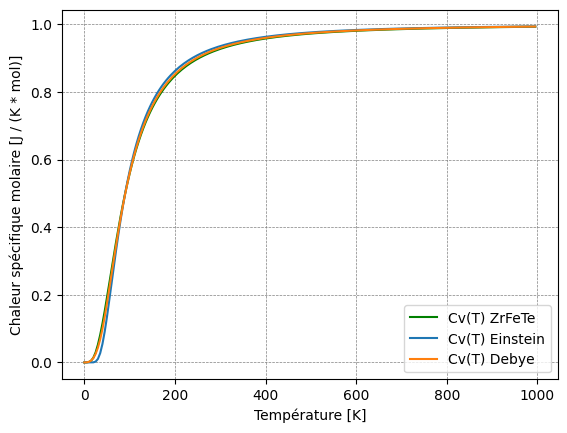

In [23]:
cv_E = []
cv_D = []
for i in T:
    #on peut calculer nos différentes valeurs de cv avce nos modèles définis plus haute et pour lesquels nous avons trouvés les T
    cv_E.append(modele_einstein(tmp_E, i));cv_D.append(modele_debye(tmp_D, i))

plt.plot(T, cv_list, color="green", label="Cv(T) ZrFeTe")
plt.plot(T, cv_E, label="Cv(T) Einstein")
plt.plot(T, cv_D, label="Cv(T) Debye")
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel("Température [K]")
plt.ylabel("Chaleur spécifique molaire [J / (K * mol)]")
plt.legend()
plt.show()

On peut voir que notre modèle de Debye est plus proche des données expérimentales, les courbes sont plus ressemblantes, cela semble logique vu que le modèle de Debye ne fait pas de aussi grosse hypothèse qu'Einstein.

## Densité d'états de phonons correspondantes

Dans le modèle de Einstein g(w) est un delta de Dirac piqué en $$ g_E(\omega) = 3 \cdot N_{\text{at}} \cdot \delta(\omega - \omega_E) $$. 
Dans le modèle de Debye g(w) est une fonction parabolique de la fréquence :$$ g_D(w) = \frac{3 \cdot N_{at} \cdot \Omega \cdot w^2}{v^{3} \cdot 2 \cdot \pi^{2}} $$ pour $$ w < w_D = v*q_D $$
et $$ g_D(w) = 0 $$ pour $$ w > w_D$$

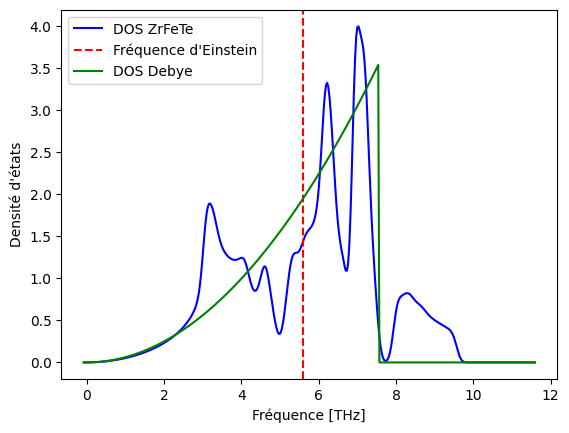

In [24]:
# fréquence de Einstein 
freq_E = tmp_E * kb / h / 10**12   # (en THz)

#  fréquence de Debye 
freq_D = tmp_D * kb / h / 10**12  # en THz

# Calcul de la densité d'états de Debye
g_D = np.zeros_like(freq)
for i in range(len(freq)):
    if freq[i] < freq_D:
        g_D[i] = 9 * nat * freq[i]**2 / ( freq_D**3)

plt.plot(freq, densities, color="blue", label="DOS ZrFeTe")
plt.axvline(x=freq_E, color='r', linestyle='--', label="Fréquence d'Einstein")
plt.plot(freq, g_D, color="green", label="DOS Debye")
plt.legend()
plt.xlabel("Fréquence [THz]")
plt.ylabel("Densité d'états")
plt.show()

On peut voir la limite de notre modèle qui ne couvre pas toute la courbe de DOS, mais il est possible que le problème vienne de ma valeur de fréquence de Debye. 
On peut observer que l'aire sous la courbe $$ g_D(w)$$ est la meme que celle sous la courbe exacte, et quelles coincident pour w-> 0. 